In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
plt.style.use(['seaborn-ticks', 'seaborn-talk'])
import seaborn as sns

import cartopy.crs as ccrs

# Setup

In [3]:
from dask.distributed import Client, progress

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=4)
cluster.adapt(minimum=1, maximum=40)
cluster

In [4]:
client = Client(cluster)
client

Client Scheduler: tcp://10.32.78.36:34275 Dashboard: /user/0000-0002-8270-4831/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


Load data

In [5]:
import intake
import util

if util.is_ncar_host():
    print("On NCAR")
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    print("On GCP")
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


On GCP


In [29]:
from collections import namedtuple

model_id = namedtuple('model_id', ['institution_id', 'source_id'])
models = [
    model_id('MIROC',  'MIROC6'),
    model_id('NCAR',  'CESM2-WACCM'),
    model_id('CCCma',  'CanESM5'),
    model_id('CAMS',  'CAMS-CSM1-0'),
    model_id('MRI',  'MRI-ESM2-0'),
    model_id('MOHC',  'UKESM1-0-LL'),
    model_id('MIROC',  'MIROC-ES2L'),
    model_id('NCAR',  'CESM2'),
    model_id('BCC', 'BCC-CSM2-MR')
]

In [31]:
def get_data(variable_id, model):
    
    institution_id = model.institution_id
    source_id = model.source_id
    
    cat = col.search(
        experiment_id=['piControl', 'historical', 'ssp585'],
        variable_id=variable_id,
        source_id=[source_id, ]
    )
    
    dset_dict = cat.to_dataset_dict(
        zarr_kwargs={'consolidated': True, 
                     'decode_times': True},
        cdf_kwargs={},
    )
    pi = f'CMIP.{institution_id}.{source_id}.piControl.Amon.gn'
    hist =  f'CMIP.{institution_id}.{source_id}.historical.Amon.gn'
    fut = f'ScenarioMIP.{institution_id}.{source_id}.ssp585.Amon.gn'

    pi_ds = dset_dict[pi]
    hist_ds = dset_dict[hist]
    fut_ds = dset_dict[fut]
    
    return pi_ds, hist_ds, fut_ds

def fit_hs(pi_ds, hist_ds, fut_ds, model):
    model_id = f'{model.institution_id}.{model.source_id}'
    hs = HawkinsSutton2012(
        pi_ds, hist_ds, fut_ds, variable_id, model_id
    )
    # hs.fit()
    return hs

In [38]:
toe_dict = {}
for m in models:
    print(m)

    pi, hist, fut = get_data('tas', m)
    hs = fit_hs(pi, hist, fut, m)
    hs.fit()
    toe = hs.time_of_emergence(2)
    toe_dict[f'{m.institution_id}.{m.source_id}'] = toe

model_id(institution_id='MIROC', source_id='MIROC6')
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 3 group(s)
Setting up the analysis...
Computing smoothed global average timeseries... 


distributed.utils - ERROR - 'tcp://10.32.5.37:46461'
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 662, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/scheduler.py", line 1524, in add_worker
    await self.handle_worker(comm=comm, worker=address)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/scheduler.py", line 2437, in handle_worker
    worker_comm = self.stream_comms[worker]
KeyError: 'tcp://10.32.5.37:46461'
distributed.utils - ERROR - 'tcp://10.32.141.19:45375'
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 662, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/scheduler.py", line 1524, in add_worker
    await self.handle_worker(comm=comm, worker=address)
  File "/srv/conda/envs/notebook/lib/python3.7/site-p

Projecting local timeseries against smoothed global average... 


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:1328: FutureWarning: The `numpy.polyfit` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


Computing interannual variabilty from PI run... 
Preparing signal-to-noise analysis... 


distributed.utils - ERROR - 'tcp://10.32.136.17:42397'
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 662, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/scheduler.py", line 1524, in add_worker
    await self.handle_worker(comm=comm, worker=address)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/scheduler.py", line 2437, in handle_worker
    worker_comm = self.stream_comms[worker]
KeyError: 'tcp://10.32.136.17:42397'
distributed.core - ERROR - 'tcp://10.32.136.17:42397'
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/core.py", line 403, in handle_comm
    result = await result
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/scheduler.py", line 1524, in add_worker
    await self.handle_worker(comm=comm, worker=address)
  File "/srv/conda/envs/notebook/l

model_id(institution_id='NCAR', source_id='CESM2-WACCM')
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 3 group(s)
Setting up the analysis...
Computing smoothed global average timeseries... 
Projecting local timeseries against smoothed global average... 


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:1328: FutureWarning: The `numpy.polyfit` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


Computing interannual variabilty from PI run... 
Preparing signal-to-noise analysis... 
model_id(institution_id='CCCma', source_id='CanESM5')
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 3 group(s)
Setting up the analysis...
Computing smoothed global average timeseries... 
Projecting local timeseries against smoothed global average... 


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:1328: FutureWarning: The `numpy.polyfit` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


Computing interannual variabilty from PI run... 
Preparing signal-to-noise analysis... 


distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://10.32.78.36:33598 remote=tcp://10.32.78.36:34275>


model_id(institution_id='CAMS', source_id='CAMS-CSM1-0')
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 3 group(s)
Setting up the analysis...
Computing smoothed global average timeseries... 
Projecting local timeseries against smoothed global average... 


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:1328: FutureWarning: The `numpy.polyfit` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


Computing interannual variabilty from PI run... 
Preparing signal-to-noise analysis... 
model_id(institution_id='MRI', source_id='MRI-ESM2-0')
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 4 group(s)
Setting up the analysis...
Computing smoothed global average timeseries... 
Projecting local timeseries against smoothed global average... 


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:1328: FutureWarning: The `numpy.polyfit` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


Computing interannual variabilty from PI run... 
Preparing signal-to-noise analysis... 
model_id(institution_id='MOHC', source_id='UKESM1-0-LL')
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 3 group(s)
Setting up the analysis...
Computing smoothed global average timeseries... 
Projecting local timeseries against smoothed global average... 


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:1328: FutureWarning: The `numpy.polyfit` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


Computing interannual variabilty from PI run... 
Preparing signal-to-noise analysis... 
model_id(institution_id='MIROC', source_id='MIROC-ES2L')
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 3 group(s)
Setting up the analysis...
Computing smoothed global average timeseries... 
Projecting local timeseries against smoothed global average... 


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:1328: FutureWarning: The `numpy.polyfit` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


Computing interannual variabilty from PI run... 
Preparing signal-to-noise analysis... 
model_id(institution_id='NCAR', source_id='CESM2')
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 3 group(s)
Setting up the analysis...
Computing smoothed global average timeseries... 
Projecting local timeseries against smoothed global average... 


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:1328: FutureWarning: The `numpy.polyfit` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


Computing interannual variabilty from PI run... 
Preparing signal-to-noise analysis... 
model_id(institution_id='BCC', source_id='BCC-CSM2-MR')
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 5 group(s)
Setting up the analysis...
Computing smoothed global average timeseries... 
Projecting local timeseries against smoothed global average... 


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:1328: FutureWarning: The `numpy.polyfit` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


Computing interannual variabilty from PI run... 
Preparing signal-to-noise analysis... 


In [39]:
print("done")

done


In [41]:
len(toe_dict)

9

In [58]:
_t.lon

<xarray.DataArray 'lon' (lon: 256)>
array([ 0.     ,  1.40625,  2.8125 , ..., -4.21875, -2.8125 , -1.40625])
Coordinates:
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... -5.625 -4.219 -2.812 -1.406
Attributes:
    axis:           X
    bounds:         lon_bnds
    long_name:      Longitude
    standard_name:  longitude
    units:          degrees_east

MIROC.MIROC6
NCAR.CESM2-WACCM
CCCma.CanESM5
CAMS.CAMS-CSM1-0
MRI.MRI-ESM2-0
MOHC.UKESM1-0-LL
MIROC.MIROC-ES2L
NCAR.CESM2
BCC.BCC-CSM2-MR


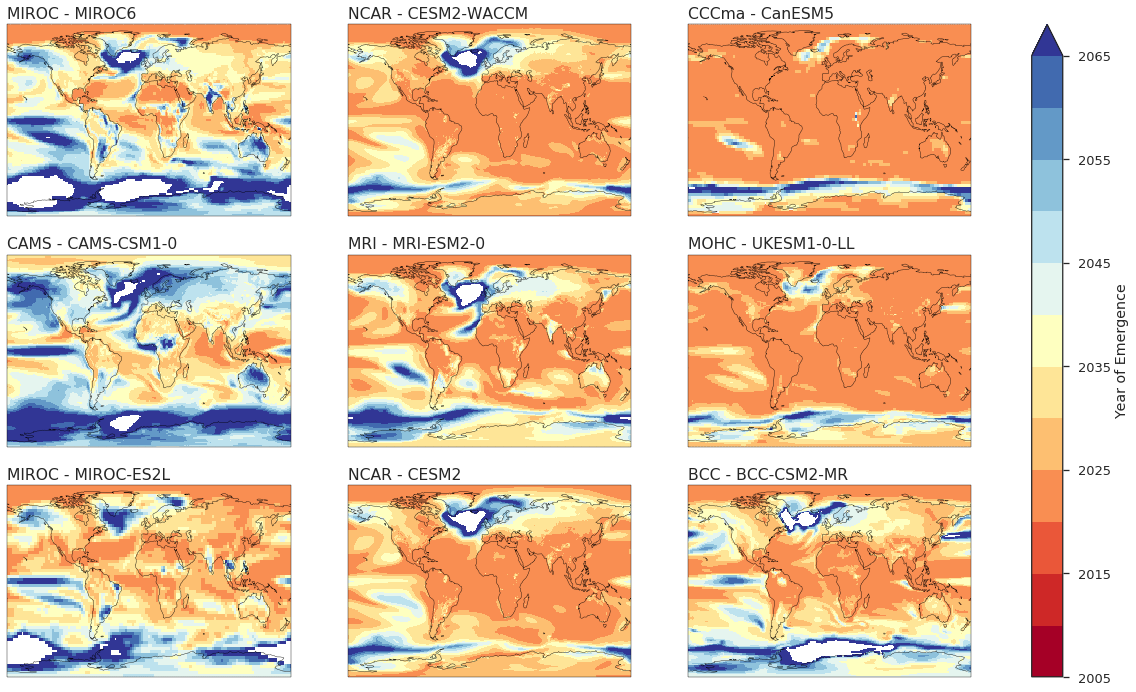

In [88]:
from tools import shift_lons, shift_roll

nrows, ncols = 3, 3
size, aspect = 4., 1.8
width, height = size*aspect*ncols, size*nrows
figsize = (width, height)

fig, axs = plt.subplots(nrows, ncols, figsize=figsize,
                        subplot_kw=dict(
                            projection=ccrs.PlateCarree(),
                            aspect='auto'
                        ))

cmap_kws = dict(
    vmin=2005, vmax=2065, extend='max', levels=13,
    cmap="RdYlBu"
)

for ax, m in zip(axs.flatten(), models):
    model_name = f'{m.institution_id}.{m.source_id}'
    print(model_name)
    
    ax.set_title(f'{m.institution_id} - {m.source_id}', loc='left')
    _t = toe_dict[model_name]['TOE'].copy()
#     _t = shift_lons(_t)
#     nlon = len(_t.lon)
#     _t = _t.roll(lon=)
    cf = _t.plot.pcolormesh('lon', 'lat', 
                            ax=ax, transform=ccrs.PlateCarree(),
                            add_colorbar=False, 
                            **cmap_kws)
    ax.coastlines()
    ax.set_aspect('auto', 'box')
#     break
    
cb = plt.colorbar(cf, ax=axs, label='Year of Emergence')
# plt.tight_layout()

plt.savefig("toe.composite.png", dpi=200, transparent=True, bbox_inches='tight')

---